In [36]:
from __future__ import print_function

In [37]:
import numpy as np
import tensorflow as tf
import sys

In [38]:
sys.path.append('../')
from src import helpers as h
from src import digit_batches as d

In [39]:
digits = d.Digits_batches([[1,2,3],[2,3,4],[3,4,1]], batch_size=128)

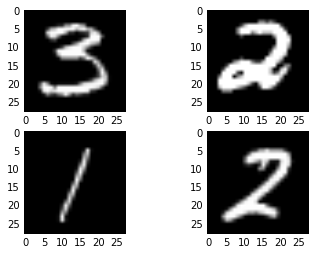

In [40]:
h.plot(digits.batches[0].next()[0])

In [41]:
from models import mlp_tensorlayer
batch_size = 128

In [42]:
Model = mlp_tensorlayer.Model

In [43]:
def restore(sess):
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoint_directory/{}'.format(model_name)))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

In [44]:
max_steps = 3001
period_print = 500
period_stat = 100

def train(model, batches_list, data = None, EWC = False, stat = False):
    
    acc_track = [[] for i in range(len(data))]
    
    p = h.Progress(max_steps*len(batches_list))
    pr = 0
    
    for ind, batches in enumerate(batches_list):
        #print("Training on batches{0}\n".format(ind+1))
        try:
            for step in range(max_steps):
                
                pr = pr+1
                p.update(pr)
                
                X, y = batches.next()
                train_d = {model.x : X, model.y_ : y}

                if EWC ==  False:
                    _ = sess.run(model.train_op, feed_dict=train_d)
                if EWC ==  True:
                    _ = sess.run(model.train_op_ewc, feed_dict=train_d)

                if step % period_stat == 0:
                    for i, d in enumerate(data):
                        acc_track[i].append(test_acc(model, d[0], d[1]))


                if (step % period_print == 0) and (stat == True):
                    test_d = {model.tf_x : X, model.tf_y : y}
                    l,ll, train_pred = sess.run([model.cost, model.ewc_cost, model.pred], feed_dict=test_d)
                    print(
                        "Step {0}: \n loss: {1} {2} \n minibatch acc: {3}% \n".format(
                            step,
                            l,
                            ll,
                            accuracy(train_pred, y)
                        )
                    )
            set_constraint(model, X, y)

        except KeyboardInterrupt:
            set_constraint(model, X, y)
            print('training interrupted')

    return acc_track

In [45]:
def test_acc(model, X, y):
    test_d = {model.x : X, model.y_ : y}
    accuracy = sess.run([model.acc], feed_dict=test_d)
    return accuracy           

In [46]:
def get_gradient(model, batches):
    X, y = batches.next()
    test_d = {model.x : X, model.y_ : y}
    gradient = sess.run([model.grads], feed_dict=test_d)
    return gradient

In [47]:
# Привязать к данным
def set_constraint(model, X, y):
    # Вычисляем Градиент по весам
    test_d = {model.x : X, model.y_ : y}
    g = sess.run([model.grads], feed_dict=test_d)

    for i, m in enumerate(model.network.all_params):
        name = m.name.split("/")[0]
        grad, w = g[0][i]
        
        with sess.as_default():
            model.f[name].assign(0.3 * np.square(grad) + 0.7 * model.f[name].eval()).eval()
            model.w[name].assign(w).eval()

In [48]:
def plot(acc_track, title):
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.rc("font", size=10)
    fig = plt.figure()
    fig.suptitle(title, fontsize=14)
    axes = plt.gca()
    axes.set_ylim([0,100])
    l = len(acc_track[0])
    for ind, acc in enumerate(acc_track):
        plt.plot(range(l), np.multiply(acc_track[ind],100.0), label='Batches {0}'.format(ind))

    plt.ylabel('accuracy, %')
    plt.xlabel('number of training batches x100')
    plt.legend(loc=4, borderaxespad=0.)
    plt.show()

In [49]:
model = Model([784,128,128,10],{'l1':0.0,'l2':0.0,'ewc':0.0}, activation = 'relu')
sess = tf.Session(graph=model.graph)
sess.run(model.init)
data = []

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 128 relu
  [TL] DenseLayer  relu2: 128 relu
  [TL] DenseLayer  output_layer: 10 identity


In [50]:
data.append(train(model, digits.batches, digits.data, EWC=False))

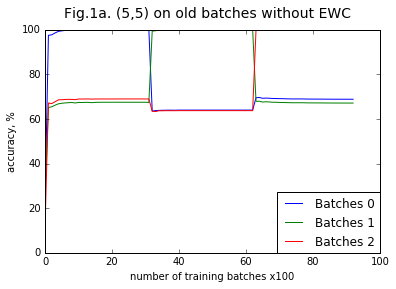

In [51]:
plot(data[0], "Fig.1a. (5,5) on old batches without EWC")

In [54]:
model = Model([784,256,256,128,64,10],{'l1':0.01,'l2':0.0,'ewc':1e20}, activation='sigmoid')
sess = tf.Session(graph=model.graph)
sess.run(model.init)
data2 = []

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 256 sigmoid
  [TL] DenseLayer  relu2: 256 sigmoid
  [TL] DenseLayer  relu3: 128 sigmoid
  [TL] DenseLayer  relu4: 64 sigmoid
  [TL] DenseLayer  output_layer: 10 identity


In [55]:
data2.append(train(model, digits.batches, digits.data, EWC=True))

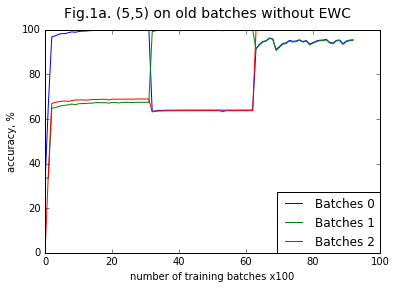

In [56]:
plot(data2[0], "Fig.1a. (5,5) on old batches without EWC")

Yyyyeah!